In [3]:
# import os
# import pandas as pd

# # Define the folder and file name
# folder_name = ""  # Change if your folder name is different
# file_name = "Cleaned_ai_job_market_insights.csv"  # Change this to the file you want

# # Construct full path
# file_path = os.path.join(folder_name, file_name)

# # Check if the file exists
# if not os.path.exists(file_path):
#     print(f"Error: The file '{file_path}' does not exist! Check your folder and filename.")
# else:
#     print(f"Loading file: {file_path}")
    
#     # Load the CSV
#     df = pd.read_csv(file_path)
    
#     # Display basic info
#     print(f" Successfully loaded: {file_name}")
#     print(f"\n Data Shape: {df.shape}")
#     print("\n First 5 rows:")
#     print(df.head())


Dataset loaded successfully.
Error: 'posting_date' column missing.


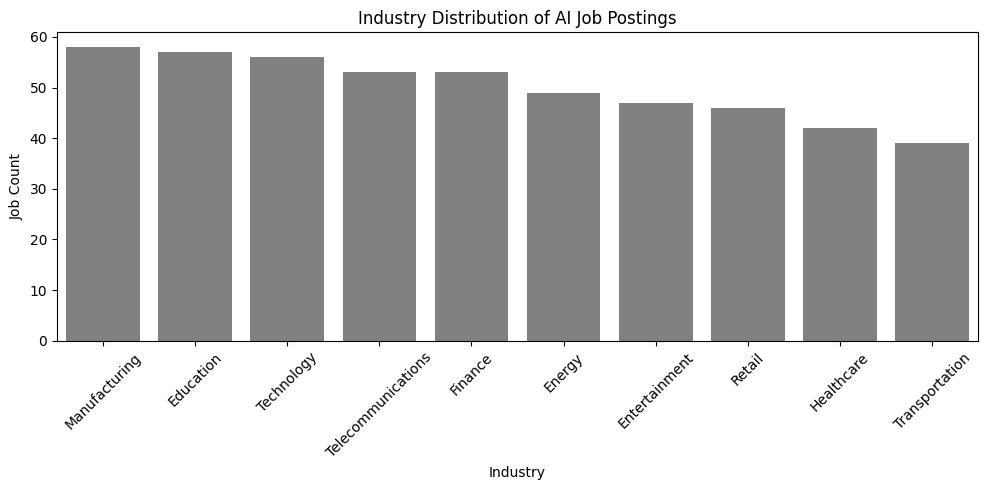

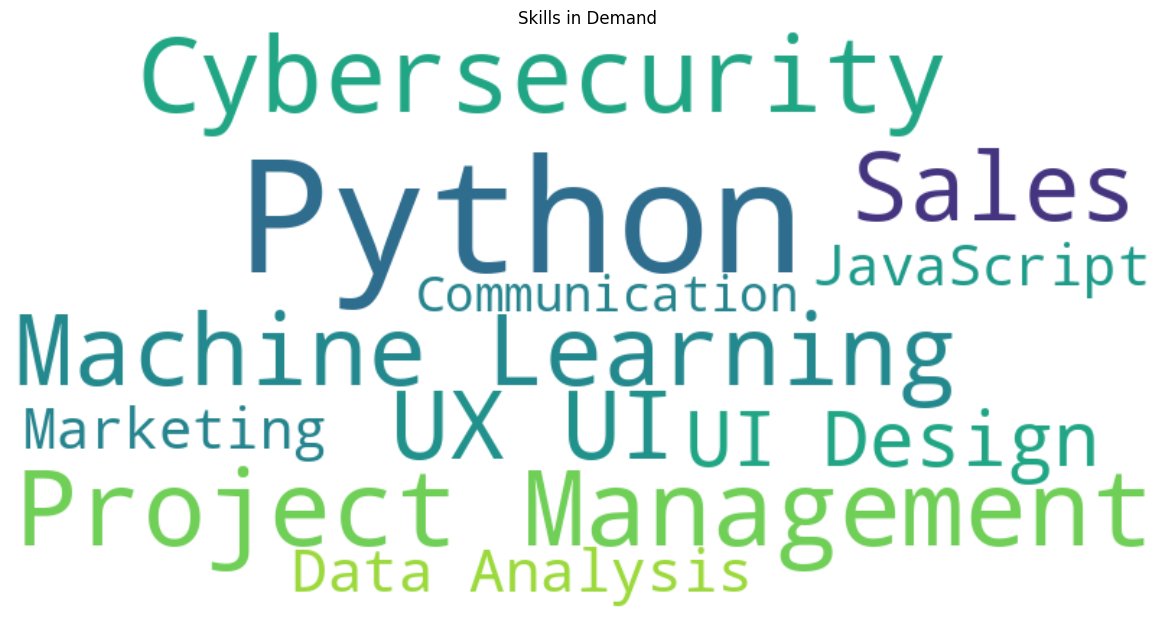

Error: 'latitude' and/or 'longitude' columns missing.
All visualizations complete.


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Define available datasets
available_files = {
    "ai_job_market_insights": "Cleaned_ai_job_market_insights.csv",
    "ai_ml_jobs_linkedin": "Cleaned_ai_ml_jobs_linkedin.csv",
    "analysis_ai_adoption": "Cleaned_Analysis_AIAdoption_AutomationRisk.csv",
    "career_change_prediction": "Cleaned_career_change_prediction_dataset.csv",
    "resume_data": "Cleaned_resume_data.csv"
}

# Load the dataset
file_name = available_files.get("ai_job_market_insights", "Cleaned_ai_job_market_insights.csv")
file_path = os.path.join("", file_name)
if not os.path.isfile(file_path):
    print(f"Error: The file '{file_path}' does not exist.")
    raise SystemExit(f"File not found: {file_path}")

try:
    df = pd.read_csv(file_path)
    print("Dataset loaded successfully.")
except Exception as e:
    print("Error loading dataset:", e)
    raise SystemExit(e)

# Ensure plots display properly
plt.ion()

# 1. Job Growth Over Time: Line Graph with Single Color
try:
    if 'posting_date' in df.columns and df['posting_date'].notnull().sum() > 0:
        df['posting_date'] = pd.to_datetime(df['posting_date'], errors='coerce')
        job_growth = df.groupby(pd.Grouper(key='posting_date', freq='M')).size().reset_index(name='job_count')
        plt.figure(figsize=(10, 5))
        sns.lineplot(data=job_growth, x='posting_date', y='job_count', marker='o', color='grey', linewidth=2, linestyle='solid')
        plt.title('AI Job Postings Over Time')
        plt.xlabel('Posting Date')
        plt.ylabel('Job Count')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("Error: 'posting_date' column missing.")
except Exception as e:
    print("Error in Job Growth Over Time visualization:", e)

# 2. Industry Distribution: Bar Chart
try:
    industry_column = next((col for col in df.columns if 'industry' in col.lower()), None)
    if industry_column:
        industry_counts = df[industry_column].value_counts().reset_index()
        industry_counts.columns = ['industry', 'job_count']
        plt.figure(figsize=(10, 5))
        sns.barplot(data=industry_counts, x='industry', y='job_count', color='grey')
        plt.title('Industry Distribution of AI Job Postings')
        plt.xlabel('Industry')
        plt.ylabel('Job Count')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("Error: Industry column missing.")
except Exception as e:
    print("Error in Industry Distribution visualization:", e)

# 3. Skills in Demand: Word Cloud
try:
    skills_column = next((col for col in df.columns if 'skill' in col.lower()), None)
    if skills_column:
        text = ' '.join(df[skills_column].dropna().tolist())
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
        plt.figure(figsize=(15, 7.5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Skills in Demand')
        plt.show()
    else:
        print("Error: Skills column missing.")
except Exception as e:
    print("Error in Skills in Demand visualization:", e)

# 4. Geographical Distribution: Scatter Plot
try:
    if 'latitude' in df.columns and 'longitude' in df.columns and df[['latitude', 'longitude']].dropna().shape[0] > 0:
        plt.figure(figsize=(8, 6))
        plt.scatter(df['longitude'], df['latitude'], alpha=0.5, color='blue', edgecolors='k')
        plt.title('Geographical Distribution of AI Job Postings')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.tight_layout()
        plt.show()
    else:
        print("Error: 'latitude' and/or 'longitude' columns missing.")
except Exception as e:
    print("Error in Geographical Distribution visualization:", e)

print("All visualizations complete.")


In [6]:
import os
import pandas as pd
import numpy as np

# ML imports
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# ----------------------------------------------------------------------------------
# 1. Load All Five Datasets
# ----------------------------------------------------------------------------------
file_paths = {
    "ai_job_market_insights": "Cleaned_ai_job_market_insights.csv",
    "ai_ml_jobs_linkedin": "Cleaned_ai_ml_jobs_linkedin.csv",
    "analysis_ai_adoption": "Cleaned_Analysis_AIAdoption_AutomationRisk.csv",
    "career_change_prediction": "Cleaned_career_change_prediction_dataset.csv",
    "resume_data": "Cleaned_resume_data.csv"
}

dfs = {}
for key, path in file_paths.items():
    if os.path.isfile(path):
        try:
            dfs[key] = pd.read_csv(path)
            print(f"{key} shape: {dfs[key].shape}")
        except Exception as e:
            print(f"Error loading {key}: {e}")
    else:
        print(f"{key} not found at {path}")

# ----------------------------------------------------------------------------------
# 2. Rename Columns for Merge Consistency
# ----------------------------------------------------------------------------------
# For the LinkedIn dataset, rename "title" -> "Job_Title", "sector" -> "Industry"
if "ai_ml_jobs_linkedin" in dfs:
    dfs["ai_ml_jobs_linkedin"] = dfs["ai_ml_jobs_linkedin"].rename(
        columns={
            "title": "Job_Title",
            "sector": "Industry"
        }
    )

# For the analysis_ai_adoption dataset
if "analysis_ai_adoption" in dfs:
    dfs["analysis_ai_adoption"] = dfs["analysis_ai_adoption"].rename(columns={
        "AI Adoption Level": "AI_Adoption_Level",
        "AI Adoption Score": "AI_Adoption_Score",
        "Automation Risk": "Automation_Risk",
        "Automation Risk Score": "Automation_Risk_Score",
        "Salary (USD)": "Salary_USD",
        "Job Growth Projection": "Job_Growth_Projection",
        "Job Growth Score": "Job_Growth_Score"
    })
    # Drop "Equivalencies" if it exists
    dfs["analysis_ai_adoption"].drop(columns=["Equivalencies"], errors="ignore", inplace=True)

# ----------------------------------------------------------------------------------
# 3. Merge DataFrames Step by Step
# ----------------------------------------------------------------------------------
# We'll start with ai_job_market_insights & analysis_ai_adoption on ["Job_Title","Industry"]
df_merged = pd.merge(
    dfs["ai_job_market_insights"],
    dfs["analysis_ai_adoption"],
    how="inner",
    on=["Job_Title","Industry"],
    suffixes=("_insights","")
)

# Merge LinkedIn data on ["Job_Title","Industry"] if relevant
if "ai_ml_jobs_linkedin" in dfs:
    df_merged = pd.merge(
        df_merged,
        dfs["ai_ml_jobs_linkedin"],
        how="left",  # or "inner" if you only want matching records
        on=["Job_Title","Industry"]
    )

# Merge career_change_prediction if relevant
# Caution: This dataset does NOT have "Job_Title" or "Industry" columns.
# So if you want to unify them, you need a different key or do it by broad "Industry" only, for instance:
if "career_change_prediction" in dfs:
    if "Industry" in dfs["career_change_prediction"].columns:
        df_merged = pd.merge(
            df_merged,
            dfs["career_change_prediction"],
            how="left",
            on="Industry"
        )
    else:
        print("career_change_prediction has no 'Industry' column, skipping direct merge.")

# Merge resume_data if relevant
# That dataset also doesn't have "Job_Title" or "Industry" in a consistent form.
# You might decide to skip or do a fuzzy merge. Below is an example if "Industry" is present:
if "resume_data" in dfs:
    # Check if "Industry" in resume_data
    if "Industry" in dfs["resume_data"].columns:
        df_merged = pd.merge(
            df_merged,
            dfs["resume_data"],
            how="left",
            on="Industry"
        )
    else:
        print("resume_data has no 'Industry' column, skipping direct merge.")

print("Combined merged DataFrame shape:", df_merged.shape)
print("Columns:", df_merged.columns)

# ----------------------------------------------------------------------------------
# 4. Drop Duplicates to Avoid Overfitting
# ----------------------------------------------------------------------------------
before_dups = df_merged.shape[0]
df_merged.drop_duplicates(inplace=True)
after_dups = df_merged.shape[0]
print(f"Dropped {before_dups - after_dups} duplicate rows. New shape: {df_merged.shape}")

# ----------------------------------------------------------------------------------
# 5. Choose the Target
# ----------------------------------------------------------------------------------
# Suppose we still want "AI_Adoption_Level" from analysis_ai_adoption
target_col = "AI_Adoption_Level"
if target_col not in df_merged.columns:
    raise ValueError(f"'{target_col}' not found in merged dataframe columns.")

# For demonstration, let's choose some features
# In practice, pick from your newly merged columns that are actually relevant
feature_candidates = [
    "Company_Size_insights",
    "Location_insights",
    "AI_Adoption_Score",
    "Automation_Risk",
    "Automation_Risk_Score",
    "Job_Growth_Projection",
    "Job_Growth_Score",
    "Required_Skills_insights",
    # Possibly from LinkedIn data:
    "companyName",
    "applicationsCount",
    # Possibly from career_change_prediction:
    "Industry Growth Rate",
    "Job Opportunities"
]

# Filter out columns that don't exist
feature_cols = [c for c in feature_candidates if c in df_merged.columns]
print("Using features:", feature_cols)

# ----------------------------------------------------------------------------------
# 6. Quick Correlation Check (Optional)
# ----------------------------------------------------------------------------------
# If your target is numeric, you'd do df_merged.corr(). But it's likely categorical.
# For a rough check if any single feature is too correlated, we can
# temporarily label-encode the target and see correlation with numeric features:

if df_merged[target_col].dtype == object:
    lbl_enc = LabelEncoder()
    df_merged["_TEMP_LABEL"] = lbl_enc.fit_transform(df_merged[target_col])
else:
    # or if it's already numeric you can skip
    df_merged["_TEMP_LABEL"] = df_merged[target_col]

# Print correlation with the target for numeric features
numeric_check = df_merged.select_dtypes(include=[np.number]).columns
print("\nCorrelation with the target:")
print(df_merged[numeric_check].corr()["_TEMP_LABEL"].sort_values(ascending=False))

# Drop temporary label
df_merged.drop(columns=["_TEMP_LABEL"], inplace=True)

# ----------------------------------------------------------------------------------
# 7. Prepare X, y
# ----------------------------------------------------------------------------------
X = df_merged[feature_cols].copy()
y = df_merged[target_col].astype(str)

# Missing values: fill numeric with mean, text with 'Unknown'
for col in feature_cols:
    if X[col].dtype in [np.float64, np.int64]:
        X[col] = X[col].fillna(X[col].mean())
    else:
        X[col] = X[col].fillna("Unknown")

# Label-encode the target
y_le = LabelEncoder()
y = y_le.fit_transform(y)

# ----------------------------------------------------------------------------------
# 8. Split BEFORE SMOTE
# ----------------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Now apply OneHotEncoder, etc. but do it in a pipeline
cat_cols = []
num_cols = []
for c in feature_cols:
    if X[c].dtype in [np.float64, np.int64]:
        num_cols.append(c)
    else:
        cat_cols.append(c)

preprocessor = ColumnTransformer(
    [
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)

# Fit preprocessor on training set only
X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans = preprocessor.transform(X_test)

# Apply SMOTE only on training
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_trans, y_train)

# ----------------------------------------------------------------------------------
# 9. Scale numeric features (optional)
# ----------------------------------------------------------------------------------
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test_trans)

# ----------------------------------------------------------------------------------
# 10. Train Initial Random Forest
# ----------------------------------------------------------------------------------
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train_res)
y_pred = model.predict(X_test_scaled)

print("\nInitial Random Forest Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=y_le.classes_))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ----------------------------------------------------------------------------------
# 11. Hyperparameter Tuning (Optional)
# ----------------------------------------------------------------------------------
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)
grid_search.fit(X_train_scaled, y_train_res)

print("\nBest parameters:", grid_search.best_params_)
best_clf = grid_search.best_estimator_
y_pred_best = best_clf.predict(X_test_scaled)

print("Tuned RF Accuracy:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best, target_names=y_le.classes_))

# ----------------------------------------------------------------------------------
# 12. Cross-Validation Example (Instead of single train/test split)
# ----------------------------------------------------------------------------------
# If you want, you can do a quick cross-validation on the entire dataset (less leakage).
# This is only an example; you might want to do cross-validation before or after any oversampling, etc.
#
# from sklearn.pipeline import Pipeline
# pipeline = Pipeline([
#     ("preprocessor", preprocessor),
#     ("scaler", StandardScaler(with_mean=False)),
#     ("rf", RandomForestClassifier(random_state=42))
# ])
# cv_scores = cross_val_score(
#     pipeline, X, y,
#     cv=5,
#     scoring='accuracy'
# )
# print("Cross-val scores:", cv_scores)
# print("Mean CV accuracy:", np.mean(cv_scores))


ai_job_market_insights shape: (500, 10)
ai_ml_jobs_linkedin shape: (847, 10)
analysis_ai_adoption shape: (23, 11)
career_change_prediction shape: (28812, 22)
resume_data shape: (4712, 21)
career_change_prediction has no 'Industry' column, skipping direct merge.
resume_data has no 'Industry' column, skipping direct merge.
Combined merged DataFrame shape: (138, 27)
Columns: Index(['Job_Title', 'Industry', 'Company_Size', 'Location',
       'AI_Adoption_Level_insights', 'Automation_Risk_insights',
       'Required_Skills_insights', 'Salary_USD_insights', 'Remote_Friendly',
       'Job_Growth_Projection_insights', 'AI_Adoption_Level',
       'AI_Adoption_Score', 'Automation_Risk', 'Automation_Risk_Score',
       'Required_Skills', 'Salary_USD', 'Job_Growth_Projection',
       'Job_Growth_Score', '                        Equivalencies', 'location',
       'publishedAt', 'companyName', 'description', 'applicationsCount',
       'contractType', 'experienceLevel', 'workType'],
      dtype='obj